In [11]:
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

In [12]:
df = pd.read_csv('codes.csv')

In [13]:
print(tf.config.list_physical_devices('GPU'))

[]


In [14]:
df['code_array'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x]).reshape(29, 29))
df['code_oned'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x]))

In [53]:
# Function to split DFT into real and imaginary parts and reshape them
def split_dft(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    imag_part = np.array([c.imag for c in complex_numbers])
    return real_part, imag_part

# Apply the function to each row
df['dft_real'], df['dft_imag'] = zip(*df['dft'].apply(split_dft))


In [18]:
def zero_pad_right(per, arr):
    index = int(per * len(arr))
    for i in range(index, len(arr)):
        arr[i] = 0
    return arr

In [61]:
def combine_dft_full(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    # real_part = zero_pad_right(0.5, real_part)
    imag_part = np.array([c.imag for c in complex_numbers])
    # imag_part = zero_pad_right(0.5, imag_part)
    return np.append(real_part, imag_part)

df['dft_stacked'] = df['dft'].apply(combine_dft_full)

In [37]:
df['dft_stacked'][0]

array([ 4.27000000e+02, -2.81751760e+00,  2.43744204e-01, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [62]:
# Features (X) - DFT components
X = np.stack(df['dft_stacked'].values)  # Shape: (num_samples, 1682)

# Labels (y) - QR codes
y = np.stack(df['code_oned'].values)  # Shape: (num_samples, 841)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# X_tr, X_te = split_data(df[']dfts, 0.8, 12345)
# y_tr, y_te = split_data(codes, 0.8, 12345)

NameError: name 'dfts' is not defined

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(29, 29, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(29 * 29 * 64, activation='relu'),  # Adjusting to match the target shape
    layers.Reshape((29, 29, 64)),
    layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')  # Output should match the shape of QR code (29x29)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [44]:
def init_model():
    model = tf.keras.Sequential()
    
    # Add the input layer (implicitly defined by the first layer)
    model.add(tf.keras.layers.InputLayer(input_shape=(1682,)))
    
    # Add the output layer with Y units (no activation for regression, 'softmax' or 'sigmoid' for classification)
    model.add(tf.keras.layers.Dense(841))
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    # Compile the model (use appropriate loss and metrics for your task)
    model.compile(optimizer=optimizer, loss='mse')  # or 'categorical_crossentropy' for classification
    return model

In [32]:
# model = Sequential([Dense(29*29*2, input_dim=29*29*2, use_bias=False)])
# model.compile(loss='mean_squared_error', optimizer='adam', )

In [40]:
# Ensure the inputs and labels are numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train.shape

(8000, 841)

In [41]:
# Convert to the correct data type
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [17]:
for set in [X_train, X_test, y_train, y_test]:
    for i in range(len(set)):
        set[i] = set[i].flatten()

ValueError: could not broadcast input array from shape (1682,) into shape (29,29,2)

In [42]:
# Train the model
model.fit(X_train, y_train, epochs=100, validation_data=[X_test[1000:], y_test[1000:]])

Epoch 1/100
250/250 [==============================] - 1s 3ms/step - loss: 40.1905 - val_loss: 34.7917
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 31.9708 - val_loss: 29.9877
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 27.6187 - val_loss: 26.2752
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 24.1023 - val_loss: 23.1507
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 21.1236 - val_loss: 20.4368
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 18.5612 - val_loss: 18.1259
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 16.3444 - val_loss: 16.0783
Epoch 8/100
250/250 [==============================] - 1s 3ms/step - loss: 14.4158 - val_loss: 14.2937
Epoch 9/100
250/250 [==============================] - 1s 3ms/step - loss: 12.7307 - val_loss: 12.7276
Epoch 10/100
250/250 [==============================] - 1s 3ms/step - los

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, num_samples=1000):
    """
    Evaluates the trained CNN model on the test set and displays a few samples with their predictions.

    Parameters:
    - model: The trained TensorFlow/Keras model.
    - X_test: The input features for the test set (shape: num_samples, 29, 29, 2).
    - y_test: The true labels for the test set (shape: num_samples, 29, 29).
    - num_samples: The number of test samples to display.

    Returns:
    - accuracy: The overall accuracy of the model on the test set.
    """
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Binarize the predictions (0 or 1)
    predictions_binarized = (predictions > 0.5).astype(np.int32).reshape(predictions.shape[0], 29, 29)

    # Calculate accuracy
    correct_predictions = np.sum(predictions_binarized == y_test)
    total_pixels = y_test.size
    accuracy = correct_predictions / total_pixels
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Display some predictions
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        # Original QR code
        plt.subplot(1, 3, 1)
        plt.title("Original QR Code")
        plt.imshow(y_test[i], cmap='gray')

        # Predicted QR code
        plt.subplot(1, 3, 2)
        plt.title("Predicted QR Code")
        plt.imshow(predictions_binarized[i], cmap='gray')

        # Difference (Error)
        plt.subplot(1, 3, 3)
        plt.title("Difference (Error)")
        plt.imshow(y_test[i] - predictions_binarized[i], cmap='gray')

        plt.show()
    
    return accuracy




32/32 [==============================] - 0s 1ms/step
Test Accuracy: 0.00%


C:\Users\kenne\AppData\Local\Temp\ipykernel_22000\1009443661.py:24: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions = np.sum(predictions_binarized == y_test)


TypeError: Invalid shape (841,) for image data

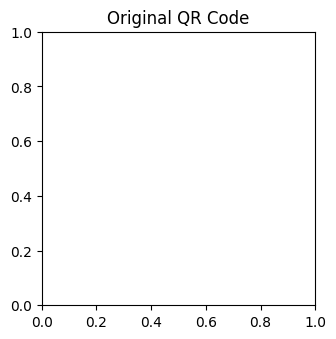

In [34]:
evaluate_model(model, X_test[:999], y_test[:999])

32/32 [==============================] - 0s 2ms/step
Test Accuracy: 99.61%


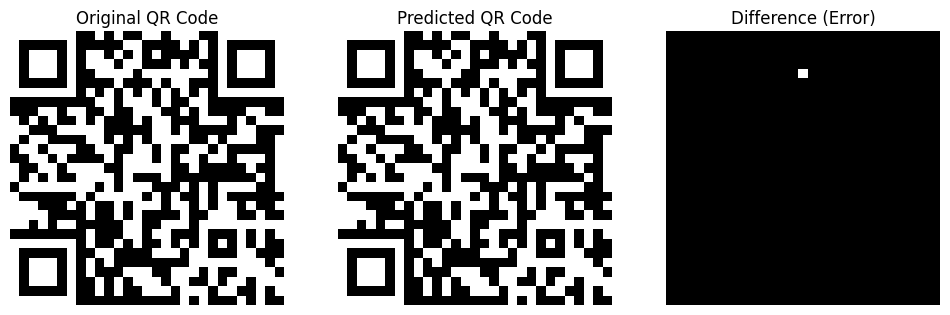

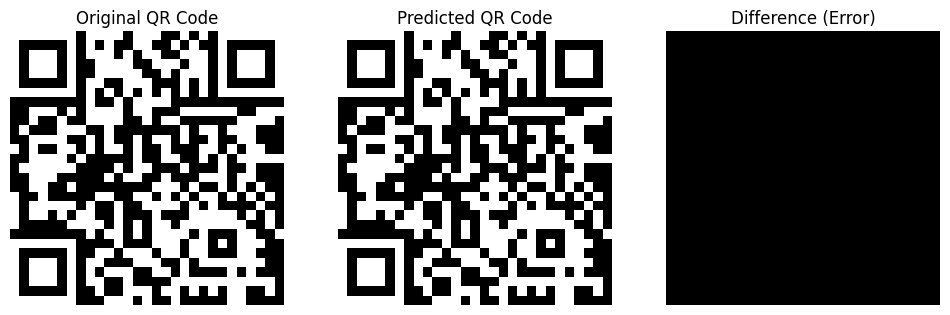

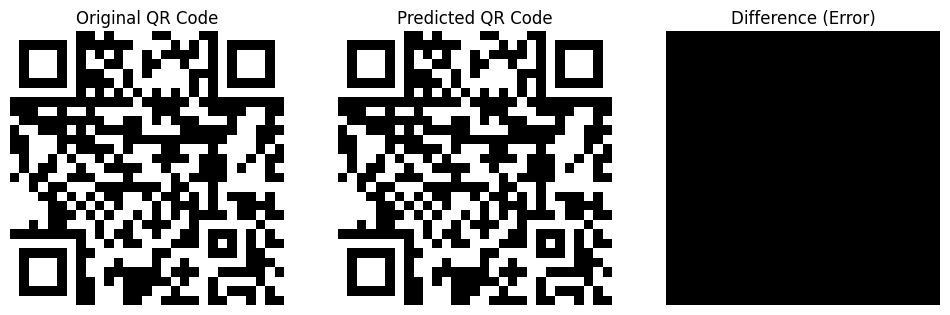

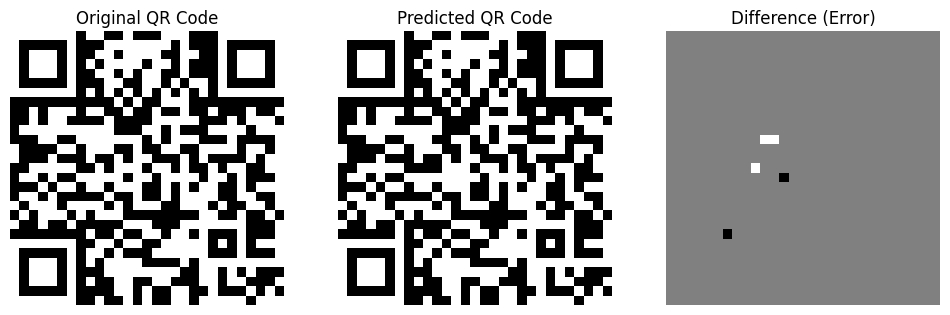

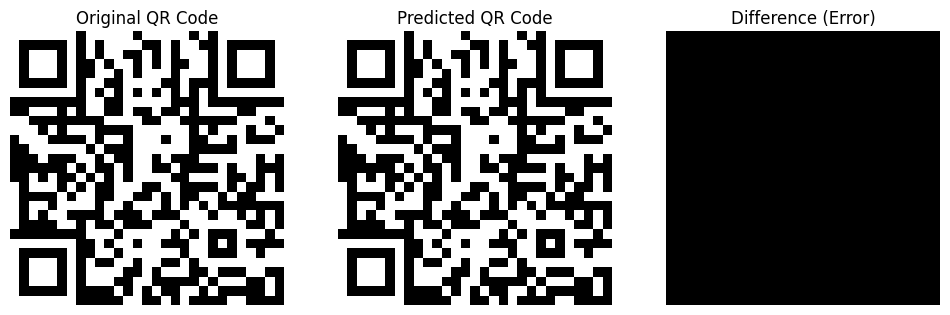

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, num_samples=5):
    """
    Evaluates the trained model on the test set and displays a few samples with their predictions.

    Parameters:
    - model: The trained TensorFlow/Keras model.
    - X_test: The input features for the test set (shape: (num_samples, 1682)).
    - y_test: The true labels for the test set (shape: (num_samples, 841)).
    - num_samples: The number of test samples to display.

    Returns:
    - accuracy: The overall accuracy of the model on the test set.
    """
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Binarize the predictions (0 or 1)
    predictions_binarized = (predictions > 0.5).astype(np.int32)
    
    # Calculate accuracy
    correct_predictions = np.sum(predictions_binarized == y_test)
    total_elements = y_test.size
    accuracy = correct_predictions / total_elements
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Display some predictions
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        # Original QR code
        plt.subplot(1, 3, 1)
        plt.title("Original QR Code")
        plt.imshow(y_test[i].reshape(29, 29), cmap='gray')
        plt.axis('off')

        # Predicted QR code
        plt.subplot(1, 3, 2)
        plt.title("Predicted QR Code")
        plt.imshow(predictions_binarized[i].reshape(29, 29), cmap='gray')
        plt.axis('off')

        # Difference (Error)
        plt.subplot(1, 3, 3)
        plt.title("Difference (Error)")
        plt.imshow(y_test[i].reshape(29, 29) - predictions_binarized[i].reshape(29, 29), cmap='gray')
        plt.axis('off')

        plt.show()
        
    return accuracy

# Example usage:
accuracy = evaluate_model(model, X_test[:999], y_test[:999], num_samples=5)


In [29]:
per_and_acc = [(1.00, 1.00), (.5, .9961)]

In [10]:
zero_pad_right(0.79, [1,2,3,4,5])

[1, 2, 3, 0, 0]

In [49]:
def combine_dft(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    real_part = zero_pad_right(per, real_part)
    imag_part = np.array([c.imag for c in complex_numbers])
    imag_part = zero_pad_right(per, imag_part)
    return np.append(real_part, imag_part)



Epoch 1/100
250/250 [==============================] - 3s 12ms/step - loss: 40.2162 - val_loss: 34.7692
Epoch 2/100
250/250 [==============================] - 3s 12ms/step - loss: 32.0382 - val_loss: 29.9360
Epoch 3/100
250/250 [==============================] - 3s 12ms/step - loss: 27.6757 - val_loss: 26.2585
Epoch 4/100
250/250 [==============================] - 3s 11ms/step - loss: 24.1433 - val_loss: 23.1480
Epoch 5/100
250/250 [==============================] - 3s 13ms/step - loss: 21.1623 - val_loss: 20.4482
Epoch 6/100
250/250 [==============================] - 3s 13ms/step - loss: 18.5931 - val_loss: 18.1047
Epoch 7/100
250/250 [==============================] - 3s 12ms/step - loss: 16.3665 - val_loss: 16.0538
Epoch 8/100
250/250 [==============================] - 3s 13ms/step - loss: 14.4325 - val_loss: 14.2812
Epoch 9/100
250/250 [==============================] - 3s 12ms/step - loss: 12.7458 - val_loss: 12.6950
Epoch 10/100
250/250 [==============================] - 3s 13ms/

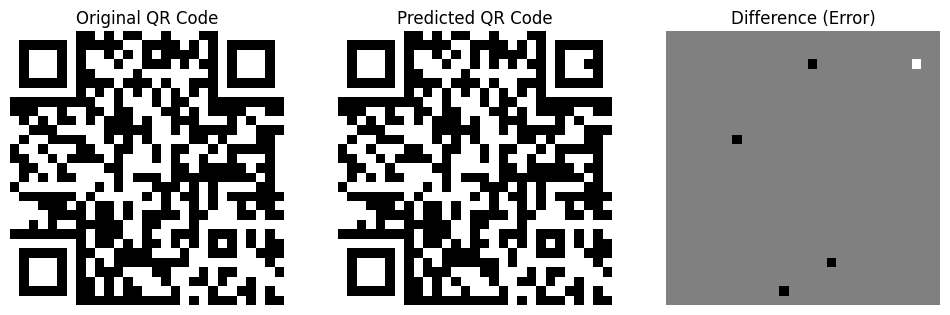

Epoch 1/100
250/250 [==============================] - 3s 11ms/step - loss: 36.3728 - val_loss: 31.4044
Epoch 2/100
250/250 [==============================] - 3s 11ms/step - loss: 28.9410 - val_loss: 27.0441
Epoch 3/100
250/250 [==============================] - 3s 11ms/step - loss: 25.0342 - val_loss: 23.7503
Epoch 4/100
250/250 [==============================] - 3s 12ms/step - loss: 21.8915 - val_loss: 20.9415
Epoch 5/100
250/250 [==============================] - 3s 11ms/step - loss: 19.2276 - val_loss: 18.5496
Epoch 6/100
250/250 [==============================] - 3s 12ms/step - loss: 16.9403 - val_loss: 16.4431
Epoch 7/100
250/250 [==============================] - 3s 11ms/step - loss: 14.9552 - val_loss: 14.6406
Epoch 8/100
250/250 [==============================] - 3s 12ms/step - loss: 13.2285 - val_loss: 13.0267
Epoch 9/100
250/250 [==============================] - 3s 12ms/step - loss: 11.7208 - val_loss: 11.6194
Epoch 10/100
250/250 [==============================] - 3s 11ms/

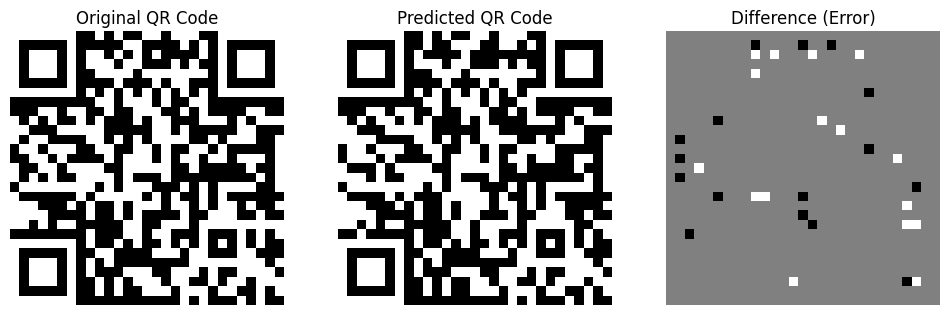

Epoch 1/100
250/250 [==============================] - 3s 12ms/step - loss: 32.5200 - val_loss: 27.9961
Epoch 2/100
250/250 [==============================] - 3s 10ms/step - loss: 25.7853 - val_loss: 24.1096
Epoch 3/100
250/250 [==============================] - 3s 11ms/step - loss: 22.3292 - val_loss: 21.2363
Epoch 4/100
250/250 [==============================] - 3s 11ms/step - loss: 19.5561 - val_loss: 18.7020
Epoch 5/100
250/250 [==============================] - 3s 11ms/step - loss: 17.2151 - val_loss: 16.5717
Epoch 6/100
250/250 [==============================] - 3s 10ms/step - loss: 15.2018 - val_loss: 14.7474
Epoch 7/100
250/250 [==============================] - 3s 10ms/step - loss: 13.4553 - val_loss: 13.1460
Epoch 8/100
250/250 [==============================] - 3s 10ms/step - loss: 11.9349 - val_loss: 11.7242
Epoch 9/100
250/250 [==============================] - 3s 10ms/step - loss: 10.6038 - val_loss: 10.4832
Epoch 10/100
250/250 [==============================] - 3s 11ms/

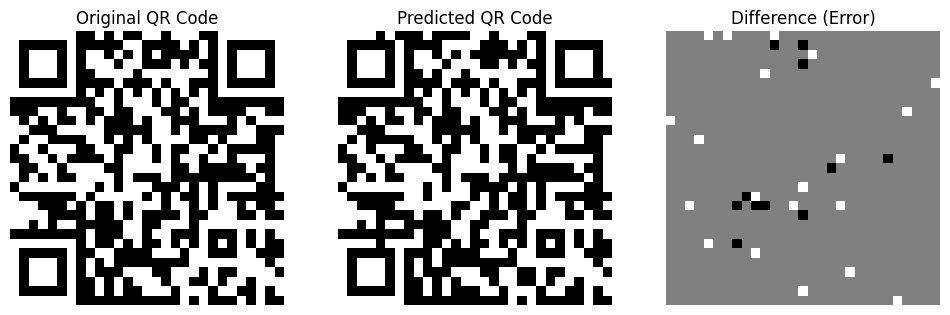

Epoch 1/100
250/250 [==============================] - 2s 7ms/step - loss: 28.6568 - val_loss: 24.6765
Epoch 2/100
250/250 [==============================] - 2s 7ms/step - loss: 22.6802 - val_loss: 21.2516
Epoch 3/100
250/250 [==============================] - 2s 8ms/step - loss: 19.6452 - val_loss: 18.6236
Epoch 4/100
250/250 [==============================] - 2s 8ms/step - loss: 17.2176 - val_loss: 16.4594
Epoch 5/100
250/250 [==============================] - 2s 9ms/step - loss: 15.1747 - val_loss: 14.5803
Epoch 6/100
250/250 [==============================] - 3s 10ms/step - loss: 13.4222 - val_loss: 12.9836
Epoch 7/100
250/250 [==============================] - 2s 9ms/step - loss: 11.9029 - val_loss: 11.6016
Epoch 8/100
250/250 [==============================] - 2s 10ms/step - loss: 10.5813 - val_loss: 10.3451
Epoch 9/100
250/250 [==============================] - 3s 11ms/step - loss: 9.4227 - val_loss: 9.2736
Epoch 10/100
250/250 [==============================] - 2s 10ms/step - l

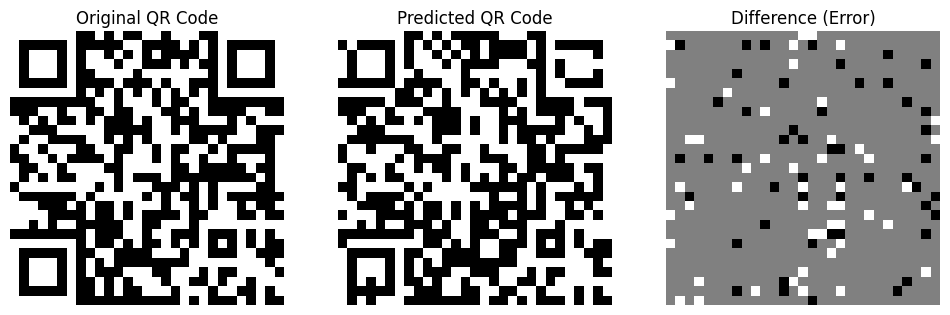

Epoch 1/100
250/250 [==============================] - 3s 10ms/step - loss: 24.8060 - val_loss: 21.1773
Epoch 2/100
250/250 [==============================] - 2s 8ms/step - loss: 19.4695 - val_loss: 18.1735
Epoch 3/100
250/250 [==============================] - 2s 8ms/step - loss: 16.8501 - val_loss: 15.9401
Epoch 4/100
250/250 [==============================] - 2s 8ms/step - loss: 14.7810 - val_loss: 14.0762
Epoch 5/100
250/250 [==============================] - 2s 8ms/step - loss: 13.0403 - val_loss: 12.5308
Epoch 6/100
250/250 [==============================] - 2s 8ms/step - loss: 11.5571 - val_loss: 11.1473
Epoch 7/100
250/250 [==============================] - 2s 8ms/step - loss: 10.2674 - val_loss: 9.9614
Epoch 8/100
250/250 [==============================] - 2s 8ms/step - loss: 9.1446 - val_loss: 8.9156
Epoch 9/100
250/250 [==============================] - 2s 8ms/step - loss: 8.1627 - val_loss: 7.9903
Epoch 10/100
250/250 [==============================] - 2s 9ms/step - loss: 7

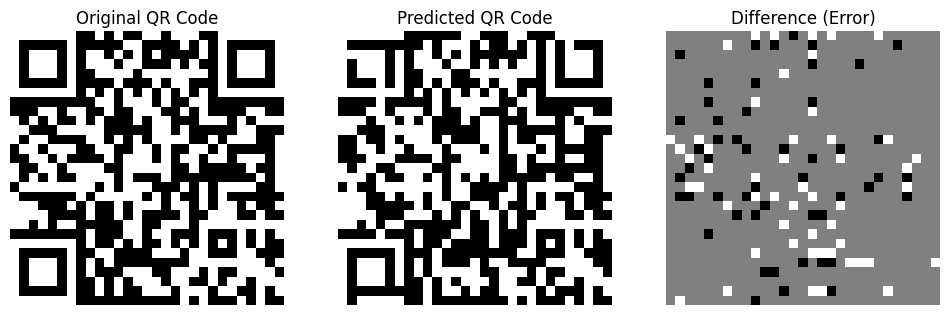

Epoch 1/100
250/250 [==============================] - 2s 7ms/step - loss: 20.7434 - val_loss: 17.7373
Epoch 2/100
250/250 [==============================] - 2s 8ms/step - loss: 16.2711 - val_loss: 15.1767
Epoch 3/100
250/250 [==============================] - 2s 8ms/step - loss: 14.0819 - val_loss: 13.2876
Epoch 4/100
250/250 [==============================] - 2s 8ms/step - loss: 12.3643 - val_loss: 11.7680
Epoch 5/100
250/250 [==============================] - 2s 8ms/step - loss: 10.9236 - val_loss: 10.4699
Epoch 6/100
250/250 [==============================] - 2s 8ms/step - loss: 9.6915 - val_loss: 9.3153
Epoch 7/100
250/250 [==============================] - 2s 8ms/step - loss: 8.6270 - val_loss: 8.3419
Epoch 8/100
250/250 [==============================] - 2s 8ms/step - loss: 7.6981 - val_loss: 7.4816
Epoch 9/100
250/250 [==============================] - 2s 8ms/step - loss: 6.8860 - val_loss: 6.7127
Epoch 10/100
250/250 [==============================] - 2s 7ms/step - loss: 6.173

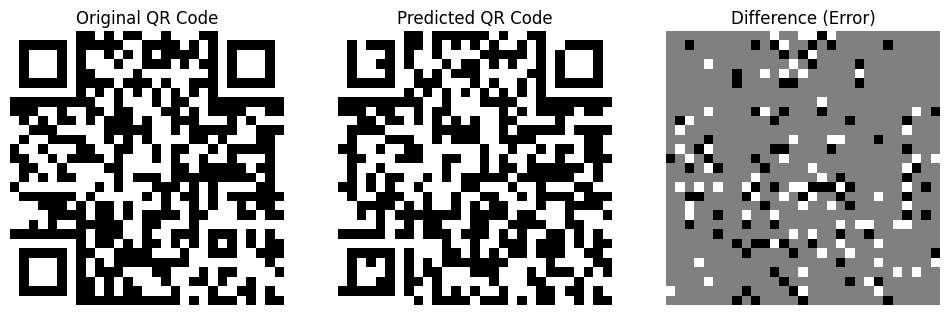

Epoch 1/100
250/250 [==============================] - 1s 4ms/step - loss: 16.9144 - val_loss: 14.2710
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 13.0538 - val_loss: 12.1546
Epoch 3/100
250/250 [==============================] - 1s 4ms/step - loss: 11.2652 - val_loss: 10.6363
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 9.8847 - val_loss: 9.4187
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 8.7353 - val_loss: 8.3627
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 7.7580 - val_loss: 7.4432
Epoch 7/100
250/250 [==============================] - 1s 4ms/step - loss: 6.9142 - val_loss: 6.6751
Epoch 8/100
250/250 [==============================] - 1s 4ms/step - loss: 6.1789 - val_loss: 5.9938
Epoch 9/100
250/250 [==============================] - 1s 4ms/step - loss: 5.5361 - val_loss: 5.3791
Epoch 10/100
250/250 [==============================] - 1s 4ms/step - loss: 4.9731 - 

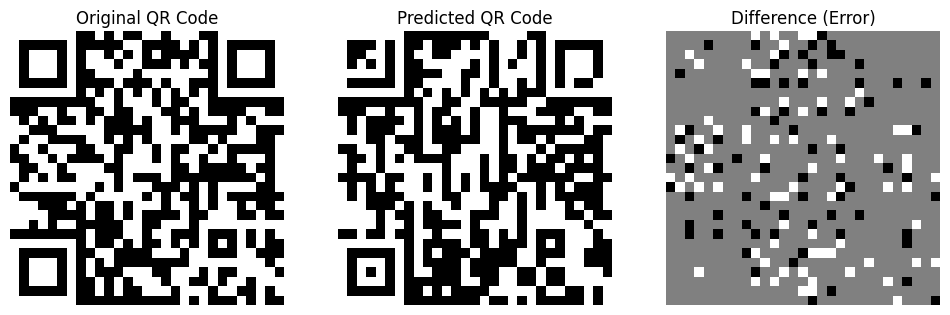

Epoch 1/100
250/250 [==============================] - 1s 3ms/step - loss: 12.8956 - val_loss: 10.7531
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 9.8447 - val_loss: 9.1199
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 8.4533 - val_loss: 7.9568
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 7.4038 - val_loss: 7.0262
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 6.5417 - val_loss: 6.2362
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 5.8109 - val_loss: 5.5541
Epoch 7/100
250/250 [==============================] - 1s 4ms/step - loss: 5.1827 - val_loss: 4.9751
Epoch 8/100
250/250 [==============================] - 1s 4ms/step - loss: 4.6402 - val_loss: 4.4787
Epoch 9/100
250/250 [==============================] - 1s 4ms/step - loss: 4.1664 - val_loss: 4.0275
Epoch 10/100
250/250 [==============================] - 1s 4ms/step - loss: 3.7519 - val_

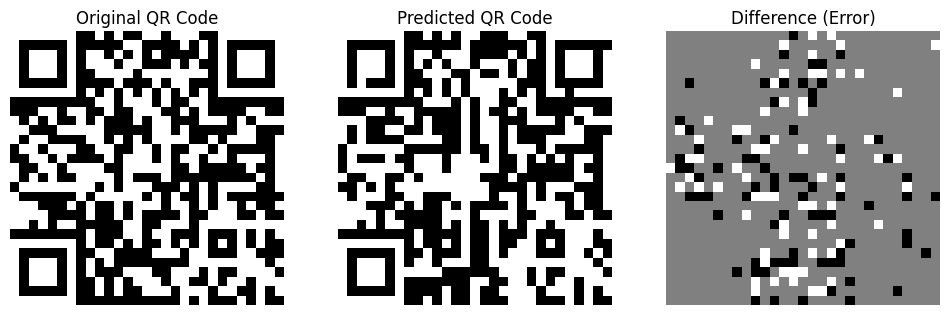

Epoch 1/100
250/250 [==============================] - 1s 3ms/step - loss: 9.0310 - val_loss: 7.3678
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 6.7054 - val_loss: 6.1577
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 5.6968 - val_loss: 5.3128
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 4.9491 - val_loss: 4.6456
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 4.3502 - val_loss: 4.1166
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 3.8528 - val_loss: 3.6573
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 3.4314 - val_loss: 3.2737
Epoch 8/100
250/250 [==============================] - 1s 4ms/step - loss: 3.0721 - val_loss: 2.9374
Epoch 9/100
250/250 [==============================] - 1s 4ms/step - loss: 2.7606 - val_loss: 2.6532
Epoch 10/100
250/250 [==============================] - 1s 4ms/step - loss: 2.4898 - val_lo

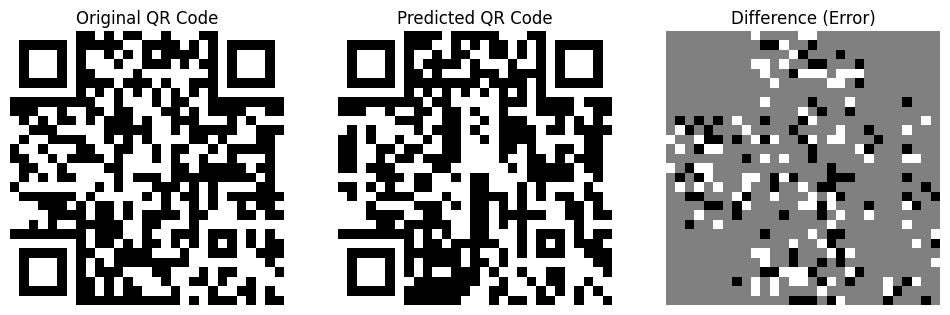

Epoch 1/100
250/250 [==============================] - 1s 4ms/step - loss: 5.0100 - val_loss: 3.7388
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 3.4050 - val_loss: 3.1048
Epoch 3/100
250/250 [==============================] - 1s 4ms/step - loss: 2.8578 - val_loss: 2.6272
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 2.4346 - val_loss: 2.2586
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 2.1011 - val_loss: 1.9771
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 1.8353 - val_loss: 1.7232
Epoch 7/100
250/250 [==============================] - 1s 4ms/step - loss: 1.6170 - val_loss: 1.5323
Epoch 8/100
250/250 [==============================] - 1s 4ms/step - loss: 1.4366 - val_loss: 1.3637
Epoch 9/100
250/250 [==============================] - 1s 4ms/step - loss: 1.2857 - val_loss: 1.2247
Epoch 10/100
250/250 [==============================] - 1s 4ms/step - loss: 1.1578 - val_lo

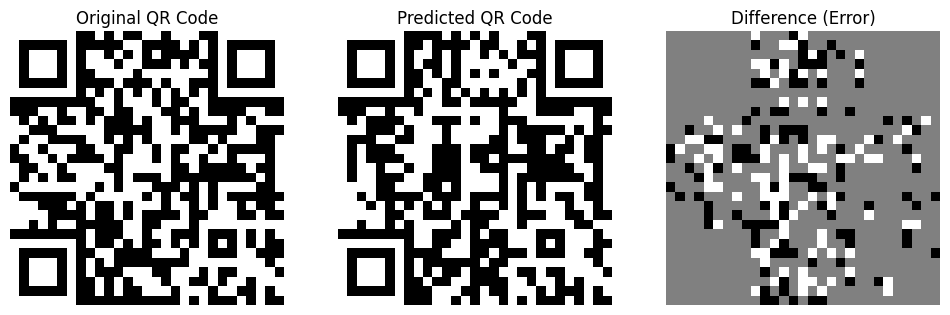

Epoch 1/100
250/250 [==============================] - 1s 3ms/step - loss: 0.5061 - val_loss: 0.5061
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.5057 - val_loss: 0.5057
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.5053 - val_loss: 0.5053
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.5049 - val_loss: 0.5049
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.5045 - val_loss: 0.5045
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.5041 - val_loss: 0.5041
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 0.5037 - val_loss: 0.5037
Epoch 8/100
250/250 [==============================] - 1s 3ms/step - loss: 0.5033 - val_loss: 0.5033
Epoch 9/100
250/250 [==============================] - 1s 4ms/step - loss: 0.5029 - val_loss: 0.5029
Epoch 10/100
250/250 [==============================] - 1s 4ms/step - loss: 0.5025 - val_lo

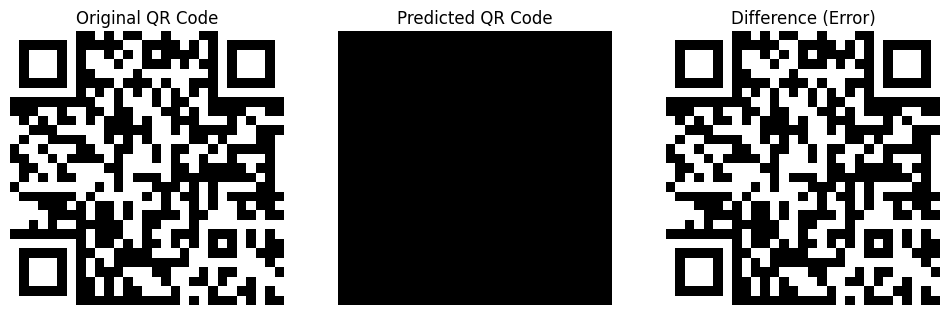

[(0.5, 0.9956436817316722), (0.45, 0.954785939328151), (0.4, 0.9238846456444554), (0.35, 0.8962351174003969), (0.3, 0.87219800061655), (0.25, 0.8430439952437574), (0.2, 0.822725222249598), (0.15, 0.8040549467422238), (0.1, 0.7877592217663562), (0.05, 0.7652337236166011), (0, 0.4927174499112668)]


In [65]:
per = .5
i = 0
stat = []
for per in [0.5, .45, .4, .35, .3, .25, .2, .15, .1, .05, 0]:
    df['dft_stacked'] = df['dft'].apply(combine_dft)
    model = init_model()
    # Features (X) - DFT components
    X = np.stack(df['dft_stacked'].values)  # Shape: (num_samples, 1682)
    
    # Split the data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #Fit the model
    model.fit(X_train, y_train, epochs=100, validation_data=[X_test[1000:], y_test[1000:]])

    accuracy = evaluate_model(model, X_test[:999], y_test[:999], num_samples=1)
    stat.append((per, accuracy))
    i += 1

print(stat)

In [63]:
X_train[0][:15]

array([441.        ,   3.14309035,  17.0771005 , -19.19212468,
       -12.21905156,   8.88602799,  18.22665256,  -4.39308678,
         2.5330769 ,  28.90213048,   5.95051907,  18.18031309,
         2.27756014,  13.43569297,  15.69209898])

32/32 [==============================] - 0s 1ms/step
Test Accuracy: 49.27%


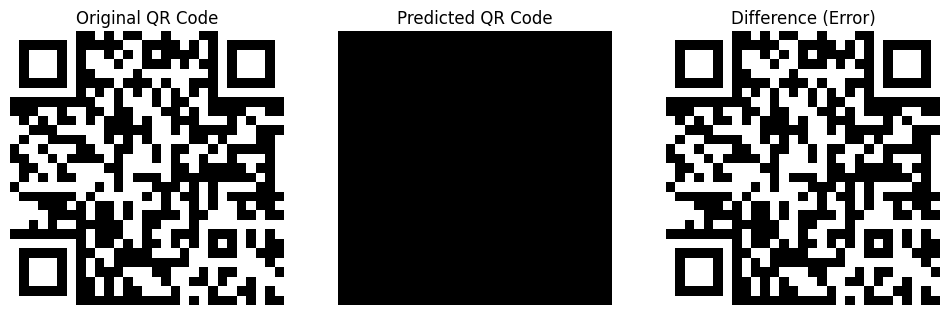

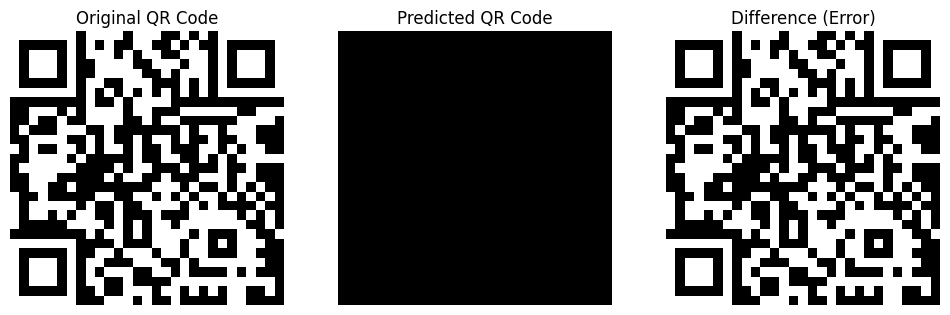

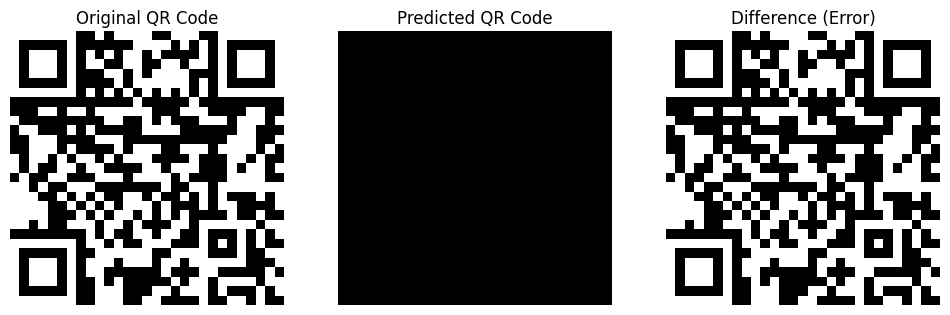

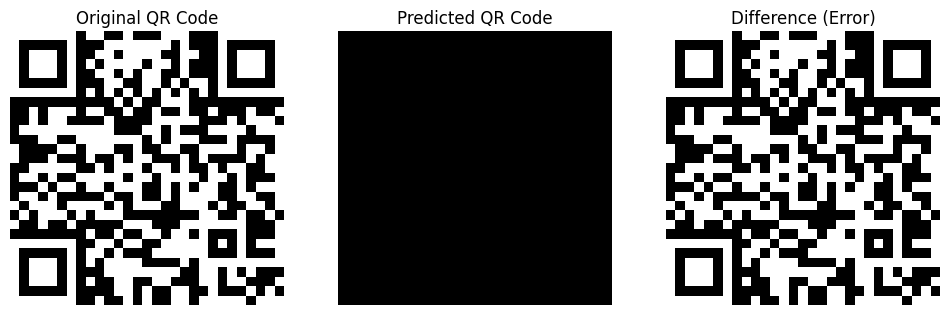

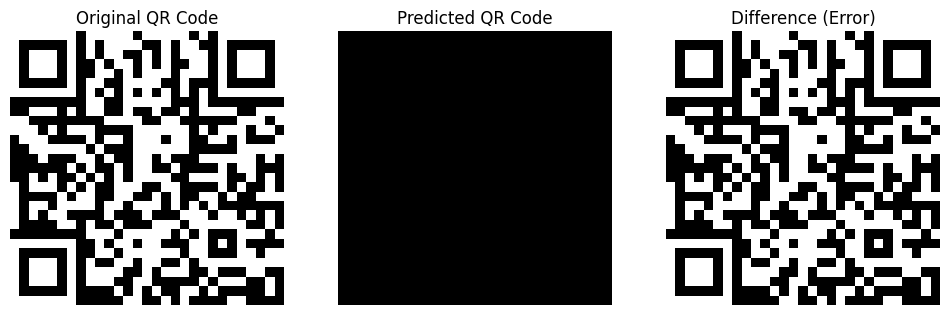

0.4927174499112668

In [66]:
evaluate_model(model, X_test[:999], y_test[:999], num_samples=5)

In [74]:
rstat = stat[::-1]
rstat

[(0, 0.4927174499112668),
 (0.05, 0.7652337236166011),
 (0.1, 0.7877592217663562),
 (0.15, 0.8040549467422238),
 (0.2, 0.822725222249598),
 (0.25, 0.8430439952437574),
 (0.3, 0.87219800061655),
 (0.35, 0.8962351174003969),
 (0.4, 0.9238846456444554),
 (0.45, 0.954785939328151),
 (0.5, 0.9956436817316722)]

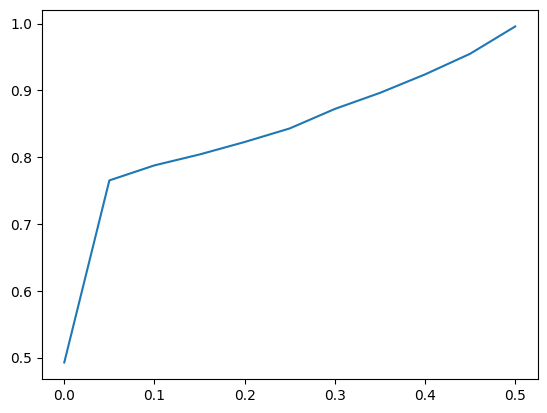

In [75]:
plt.plot([st[0] for st in rstat], [st[1] for st in rstat])